In [1]:
import os

import pandas as pd
import seaborn as sns

import scanpy as sc
from scipy.cluster.vq import kmeans2

# pip install concordex
from concordex.tools import calculate_concordex

import session_info 

We begin by loading the STARmap dataset generated and described in the manuscripted titled [Three-dimensional intact-tissue sequencing of single-cell transcriptional states](https://doi.org/10.1126/science.aat5691) (2018). 

In [2]:
data_dir = "./data/"
fn = "starmap_processed.h5ad"

ad = sc.read_h5ad(os.path.join(data_dir, fn))

These data were processed as described in the [concordex]() manuscript. Briefly, we retained cells with at least 50 total counts and retained genes expressed in at least 50 cells. After filtering, 1207 cells and 1016 genes were available for analysis. We used the analytic pearson residuals to normalize the counts and compute the first 50 PCs. 

The spatial coordinates can be accessed in the ``adata.obsm['spatial']`` attribute. 

In [3]:
ad

AnnData object with n_obs × n_vars = 1207 × 1016
    obs: 'CellID', 'total_counts', 'x', 'y', 'label', 'region', 'annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'pca', 'pearson_residuals_normalization'
    obsm: 'X_pca', 'spatial'
    varm: 'PCs'

`concordex` can compute the neighborhood consolidation matrix using discrete or continuous labels. It searches for labels in the `ad.obs` and `ad.obsm` attributes, and will raise an error if the label is not found in either. If multiple discrete labels are available, they can be provided as a list to the `labels` argument in `calculate_concordex()`. 

As an example, consider the discrete labels  ``ad.obs['region']`` and ``ad.obs['annotation']`` which represent the tissue region and cell type assigned to each cell, respectively. In the cell below, we demonstrate using both labels. Of course, this is for demonstration purposes only, and we do not recommend using the ground truth tissue region annotations to compute the neighborhood consolidation matrix. 

In [4]:
calculate_concordex(ad, ['annotation','region'], use_rep="spatial", compute_similarity=True)

Computing nearest neighbors...

Computing neighborhood consolidation and similarity matrices...



When we inspect the column names of the neighborhood consolidation matrix, we can see that the labels have been concatenated with an underscore. 

In [5]:
ad.uns['nbc_params']['nbc_colnames']

['CC_Astro-1',
 'CC_Astro-2',
 'CC_Endo',
 'CC_Micro',
 'CC_Oligo',
 'CC_Reln',
 'CC_SST',
 'CC_Smc',
 'CC_eL5',
 'CC_eL6-1',
 'CC_eL6-2',
 'HPC_Astro-1',
 'HPC_Astro-2',
 'HPC_Endo',
 'HPC_HPC',
 'HPC_Micro',
 'HPC_Oligo',
 'HPC_PVALB',
 'HPC_Reln',
 'HPC_SST',
 'HPC_VIP',
 'HPC_eL4',
 'HPC_eL5',
 'HPC_eL6-2',
 'L1_Astro-2',
 'L1_Endo',
 'L1_Micro',
 'L1_Oligo',
 'L1_PVALB',
 'L1_Reln',
 'L1_SST',
 'L1_Smc',
 'L1_VIP',
 'L1_eL2/3',
 'L1_eL4',
 'L1_eL6-1',
 'L1_eL6-2',
 'L2/3_Astro-2',
 'L2/3_Endo',
 'L2/3_Micro',
 'L2/3_Oligo',
 'L2/3_PVALB',
 'L2/3_Reln',
 'L2/3_SST',
 'L2/3_VIP',
 'L2/3_eL2/3',
 'L2/3_eL4',
 'L2/3_eL5',
 'L2/3_eL6-1',
 'L2/3_eL6-2',
 'L4_Astro-1',
 'L4_Astro-2',
 'L4_Endo',
 'L4_Micro',
 'L4_Oligo',
 'L4_PVALB',
 'L4_Reln',
 'L4_SST',
 'L4_eL2/3',
 'L4_eL4',
 'L4_eL5',
 'L4_eL6-1',
 'L4_eL6-2',
 'L5_Astro-1',
 'L5_Astro-2',
 'L5_Endo',
 'L5_HPC',
 'L5_Micro',
 'L5_Oligo',
 'L5_PVALB',
 'L5_Reln',
 'L5_SST',
 'L5_VIP',
 'L5_eL4',
 'L5_eL5',
 'L5_eL6-1',
 'L5_eL6-2',


The similarity information can be found in `ad.uns['nbc_params']['similarity']`. It represents how heterogeneous or homogenous the spatial neighborhoods are with respect to the provided labels. We'll plot it for completeness. 

In [7]:
sim = ad.uns['nbc_params']['similarity']

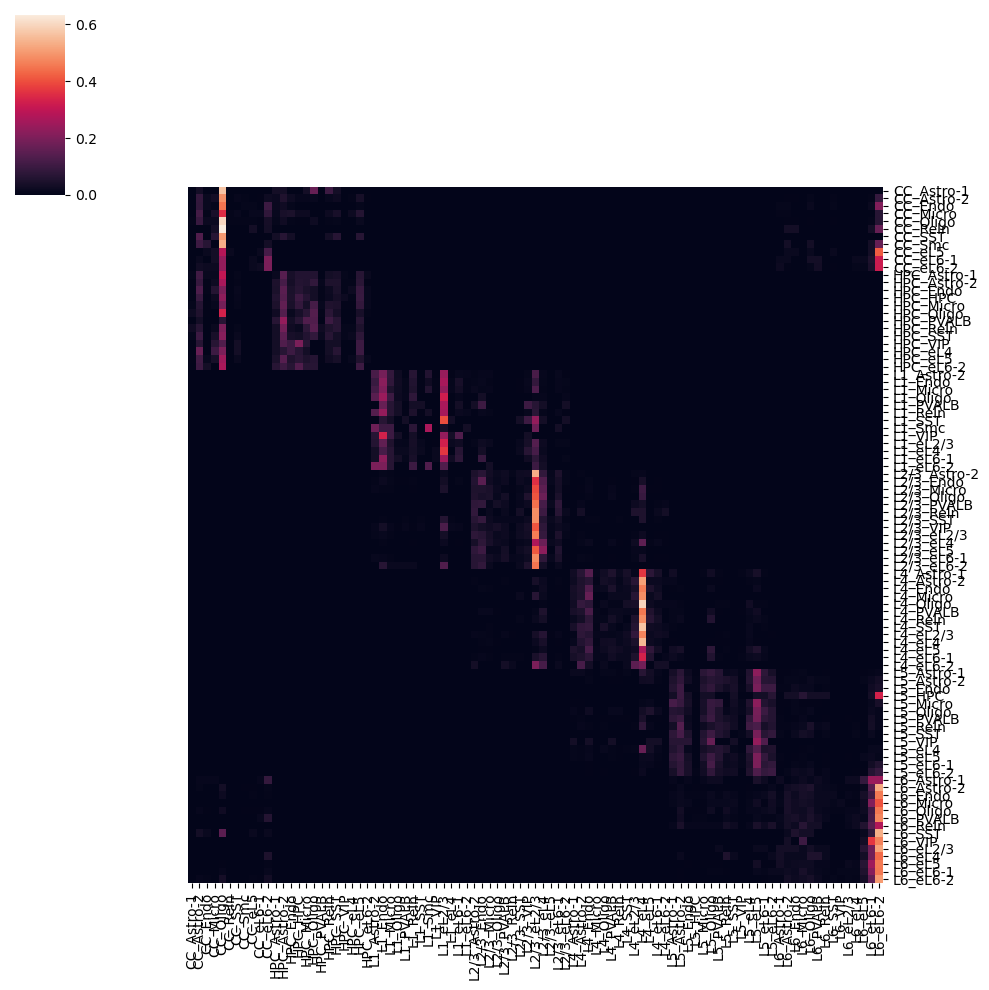

In [8]:
# Make sure axes are properly labeled
axlabs = ad.uns['nbc_params']['labelorder']
cg = cg = sns.clustermap(
    sim,
    row_cluster=False,
    col_cluster=False,
    xticklabels=axlabs, yticklabels=axlabs
)

Now, we will compute the neighborhood consolidation matrix again, this time using the precomputed principal components (PCs) to label the neighborhood graph. The PCs can be accessed in the ``ad.obsm['X_pca']`` attribute. Here, it is important to note that `concordex` priortizes labels that are identified in the `ad.obs` attribute. That is, if any of the supplied labels are found in the `ad.obs` attribute, those will take precedence, and labels found in the ``ad.obsm`` attribute will be ignored.

We'll set ``recompute_index=True`` to ensure that the nearest-neighbor graph is computed again. 

In [9]:
calculate_concordex(ad, "X_pca", use_rep='spatial', n_neighbors=30, recompute_index=True)

Computing nearest neighbors...

Computing neighborhood consolidation matrix...



`calculate_concordex()` adds the ``'X_nbc'`` and ``'index'`` keys  to the ``ad.obsm`` attribute. The nearest-neighbor graph is stored in ``ad.obsm['index']``, and the neighborhood consolidaiton matrix is stored in ``ad.obsm['X_nbc']``. We will use the consolidation matrix to identify SHRs in future steps. 

In [10]:
ad

AnnData object with n_obs × n_vars = 1207 × 1016
    obs: 'CellID', 'total_counts', 'x', 'y', 'label', 'region', 'annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'pca', 'pearson_residuals_normalization', 'index_params', 'nbc_params'
    obsm: 'X_pca', 'spatial', 'index', 'X_nbc'
    varm: 'PCs'

Before identifying SHRs, we'll take a look at the ground truth annotations. The authors have annotated 7 regions in this tissue, so we will use k-means in the steps below.

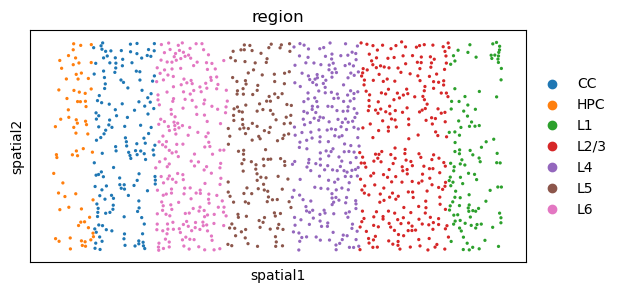

In [11]:
sc.pl.spatial(ad, color="region", spot_size=10, size=10)

The seed has been set to reproduce the results presented in the concordex manuscript. Take note that altering the seed may lead to slight variation in the reuslts due to randomization in in the kmeans algorithm.

In [12]:
n_shrs = 7

_, shr = kmeans2(ad.obsm['X_nbc'], n_shrs, seed=9)
ad.obs['shr'] = pd.Categorical(shr)

Here, we'll plot the SHRs

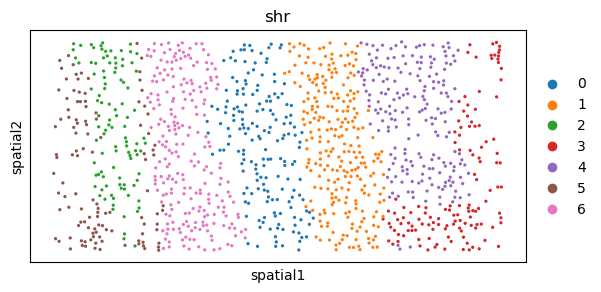

In [13]:
sc.pl.spatial(ad, color="shr", spot_size=10, size=10)

In [14]:
session_info.show()